# Import dependencies

In [19]:
import os
import pandas as pd
import numpy as np

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing

Corpus generated using Chat-GPT

In [47]:
corpus = [
    "The sky is blue. The clouds are fluffy. Birds are flying overhead.",
    "A red car is speeding down the road. It honks as it passes by.",
    "She has a green garden. The flowers bloom beautifully in spring.",
    "The coffee shop is busy. People are chatting over cups of hot coffee.",
    "Mountains surround the peaceful village. The air is crisp and clean.",
    "A black cat is sleeping on the windowsill. The rain is gently tapping on the glass.",
    "In the kitchen, a chef is preparing a delicious meal. The aroma fills the entire house.",
    "Children are playing in the park. Laughter and joy echo through the air.",
    "An old book sits on the dusty shelf. Its pages tell tales of a bygone era.",
    "The train station is crowded. Travelers rush to catch their departing trains.",
    "A yellow school bus stops to pick up excited children. Backpacks swing as they board.",
    "The river flows peacefully. Ducks swim gracefully in the calm water.",
    "A guitar player sits on a street corner, strumming a melodic tune. Passersby drop coins into the open guitar case.",
    "The sun sets behind the hills, painting the sky in shades of orange and pink.",
    "A scientist works diligently in the lab, conducting experiments to unlock new discoveries.",
    "A marathon is in progress. Runners push themselves to reach the finish line.",
    "A group of friends gathers around a bonfire, sharing stories and roasting marshmallows.",
    "The astronaut floats in space, gazing at the Earth below. The beauty of the planet is breathtaking.",
    "A bustling market is filled with colorful stalls. Vendors call out, enticing customers to buy their goods.",
    "The clock in the living room ticks softly. Time passes with each rhythmic beat."
]

## Vectorize data

### Binary Term Frequency

In [56]:
binary_term = TfidfVectorizer(
    binary=True,
    lowercase=True,
    stop_words='english',
    norm=None,
    use_idf=False,
    smooth_idf=False,
)

In [57]:
df = pd.DataFrame(
    binary_term.fit_transform(corpus).toarray(), 
    columns=binary_term.get_feature_names_out()
)

Each row $i$ signalizes if a word is in the $i$-th sentence. The columns are the words in the corpus.

In [58]:
df.head(5)

,air,aroma,astronaut,backpacks,beat,beautifully,beauty,birds,black,bloom,...,trains,travelers,tune,unlock,vendors,village,water,windowsill,works,yellow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Normalized TF-IDF

In [60]:
bag_of_words = TfidfVectorizer(
    binary=True,
    lowercase=True,
    stop_words='english',
    norm='l2',
)

In [61]:
tf_df = pd.DataFrame(
    bag_of_words.fit_transform(corpus).toarray(), 
    columns=bag_of_words.get_feature_names_out()
)

In [63]:
tf_df.head(5)

,air,aroma,astronaut,backpacks,beat,beautifully,beauty,birds,black,bloom,...,trains,travelers,tune,unlock,vendors,village,water,windowsill,works,yellow
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.384256,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.408248,0.0,0.000000,0.0,0.408248,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.337766,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.384256,0.0,0.0,0.0,0.0


# Text Classification

In [64]:
input_df = pd.read_csv('../data/spam_ham.csv')

In [65]:
input_df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [71]:
X = input_df['Message']
y = input_df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
model = make_pipeline(TfidfVectorizer(), XGBClassifier())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



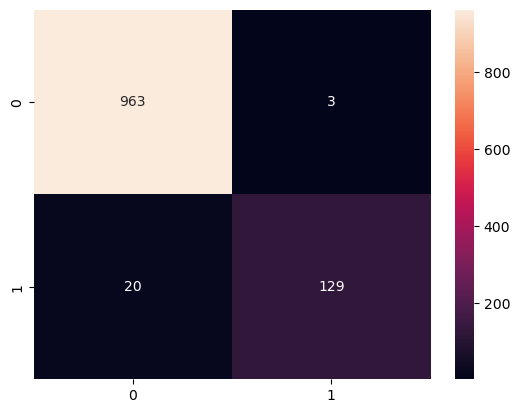

In [76]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.show()